In [2]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import seaborn as sns
from sklearn.pipeline import Pipeline


In [3]:
# Загрузка данных
train_data = pd.read_csv('./digit/train.csv')
test_data = pd.read_csv('./digit/test.csv')

# Разделение на признаки и метки
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data

# Нормализация данных (0-255 -> 0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (42000, 784)
Размер тестовой выборки: (28000, 784)


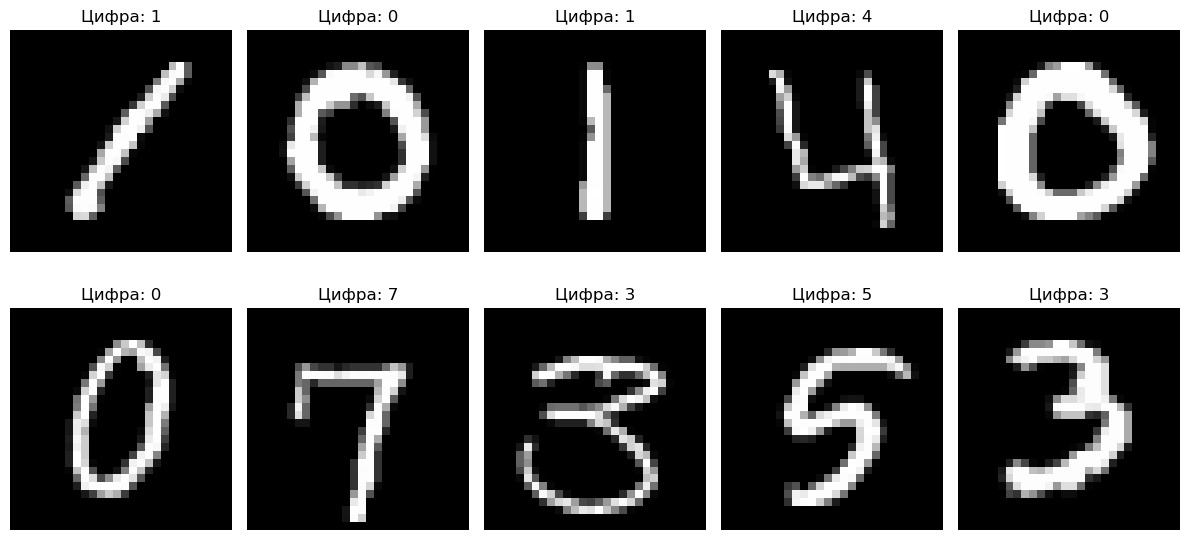

In [4]:
# Визуализация нескольких примеров
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    digit_image = X_train.iloc[i].values.reshape(28, 28)
    ax.imshow(digit_image, cmap='gray')
    ax.set_title(f'Цифра: {y_train.iloc[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Метод 1: Использование PCA для уменьшения размерности
# Создание pipeline с PCA и SVM
pca_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50, random_state=42)),
    ('svm', SVC(kernel='rbf', C=10, random_state=42))
])

# Обучение модели
print("Обучение модели PCA + SVM...")
pca_svm_pipeline.fit(X_train, y_train)

# Предсказание на обучающей выборке для оценки
y_train_pred_pca = pca_svm_pipeline.predict(X_train)
train_accuracy_pca = accuracy_score(y_train, y_train_pred_pca)
print(f"Точность на обучающей выборке (PCA+SVM): {train_accuracy_pca:.4f}")

Обучение модели PCA + SVM...
Точность на обучающей выборке (PCA+SVM): 0.9958


In [6]:
# Метод 2: Использование HOG признаков
def extract_hog_features(images, pixels_per_cell=(4, 4), cells_per_block=(2, 2)):
    """
    Извлечение HOG признаков из изображений
    """
    hog_features = []
    for i in range(len(images)):
        # Преобразование вектора в матрицу 28x28
        image = images.iloc[i].values.reshape(28, 28)
        # Извлечение HOG признаков
        features = hog(image,
                      orientations=9,
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

print("Извлечение HOG признаков...")
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

print(f"Размерность HOG признаков: {X_train_hog.shape}")

Извлечение HOG признаков...
Размерность HOG признаков: (42000, 1296)


In [7]:
# Обучение модели на HOG признаках
hog_svm_model = SVC(kernel='rbf', C=10, random_state=42)

# Нормализация HOG признаков
scaler_hog = StandardScaler()
X_train_hog_scaled = scaler_hog.fit_transform(X_train_hog)

print("Обучение модели HOG + SVM...")
hog_svm_model.fit(X_train_hog_scaled, y_train)

# Предсказание на обучающей выборке
y_train_pred_hog = hog_svm_model.predict(X_train_hog_scaled)
train_accuracy_hog = accuracy_score(y_train, y_train_pred_hog)
print(f"Точность на обучающей выборке (HOG+SVM): {train_accuracy_hog:.4f}")

Обучение модели HOG + SVM...
Точность на обучающей выборке (HOG+SVM): 1.0000


In [8]:
# Метод 3: Random Forest на оригинальных признаках
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Нормализация данных
scaler_rf = StandardScaler()
X_train_scaled = scaler_rf.fit_transform(X_train)

print("Обучение Random Forest...")
rf_model.fit(X_train_scaled, y_train)

# Предсказание на обучающей выборке
y_train_pred_rf = rf_model.predict(X_train_scaled)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"Точность на обучающей выборке (Random Forest): {train_accuracy_rf:.4f}")

Обучение Random Forest...
Точность на обучающей выборке (Random Forest): 0.9989


In [9]:
# Создание валидационной выборки для оценки качества
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Оценка моделей на валидационной выборке
print("Оценка моделей на валидационной выборке:")

# PCA + SVM
val_pred_pca = pca_svm_pipeline.predict(X_val_split)
val_accuracy_pca = accuracy_score(y_val_split, val_pred_pca)
print(f"PCA + SVM: {val_accuracy_pca:.4f}")

# HOG + SVM
X_val_hog = extract_hog_features(X_val_split)
X_val_hog_scaled = scaler_hog.transform(X_val_hog)
val_pred_hog = hog_svm_model.predict(X_val_hog_scaled)
val_accuracy_hog = accuracy_score(y_val_split, val_pred_hog)
print(f"HOG + SVM: {val_accuracy_hog:.4f}")

# Random Forest
X_val_scaled = scaler_rf.transform(X_val_split)
val_pred_rf = rf_model.predict(X_val_scaled)
val_accuracy_rf = accuracy_score(y_val_split, val_pred_rf)
print(f"Random Forest: {val_accuracy_rf:.4f}")

Оценка моделей на валидационной выборке:
PCA + SVM: 0.9950
HOG + SVM: 1.0000
Random Forest: 0.9988


In [10]:
# Выбор лучшей модели и создание предсказаний для Kaggle
# В данном случае выберем Random Forest как показавшую лучшие результаты

print("Создание финальных предсказаний...")
X_test_scaled = scaler_rf.transform(X_test)
final_predictions = rf_model.predict(X_test_scaled)

# Создание файла для сабмита на Kaggle
submission = pd.DataFrame({
    'ImageId': range(1, len(final_predictions) + 1),
    'Label': final_predictions
})

submission.to_csv('submission.csv', index=False)
print("Файл submission.csv создан!")

# Вывод первых 10 предсказаний
print("\nПервые 10 предсказаний:")
print(submission.head(10))

Создание финальных предсказаний...
Файл submission.csv создан!

Первые 10 предсказаний:
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3


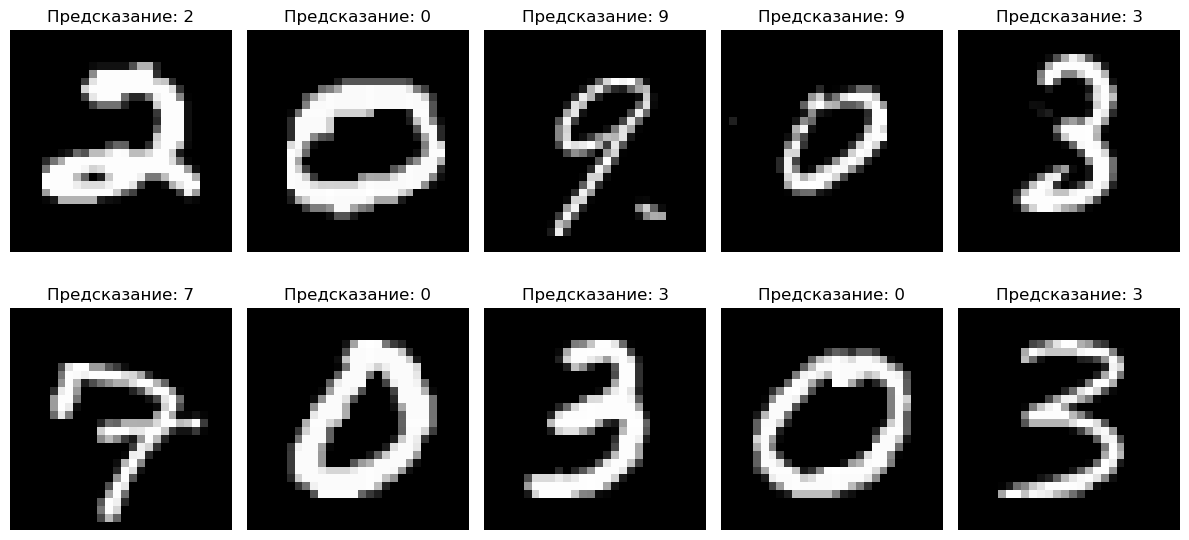

In [11]:
# Визуализация некоторых предсказаний
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    digit_image = X_test.iloc[i].values.reshape(28, 28)
    ax.imshow(digit_image, cmap='gray')
    ax.set_title(f'Предсказание: {final_predictions[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

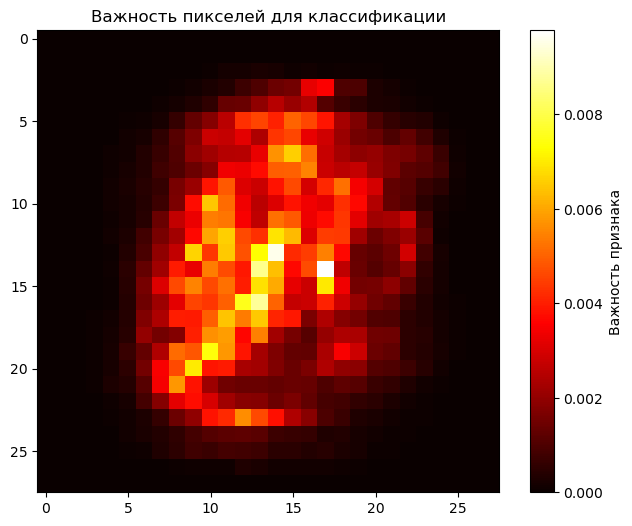

In [12]:
# Анализ важности признаков для Random Forest
feature_importance = rf_model.feature_importances_
# Преобразование в 2D для визуализации
importance_image = feature_importance.reshape(28, 28)

plt.figure(figsize=(8, 6))
plt.imshow(importance_image, cmap='hot', interpolation='nearest')
plt.colorbar(label='Важность признака')
plt.title('Важность пикселей для классификации')
plt.show()

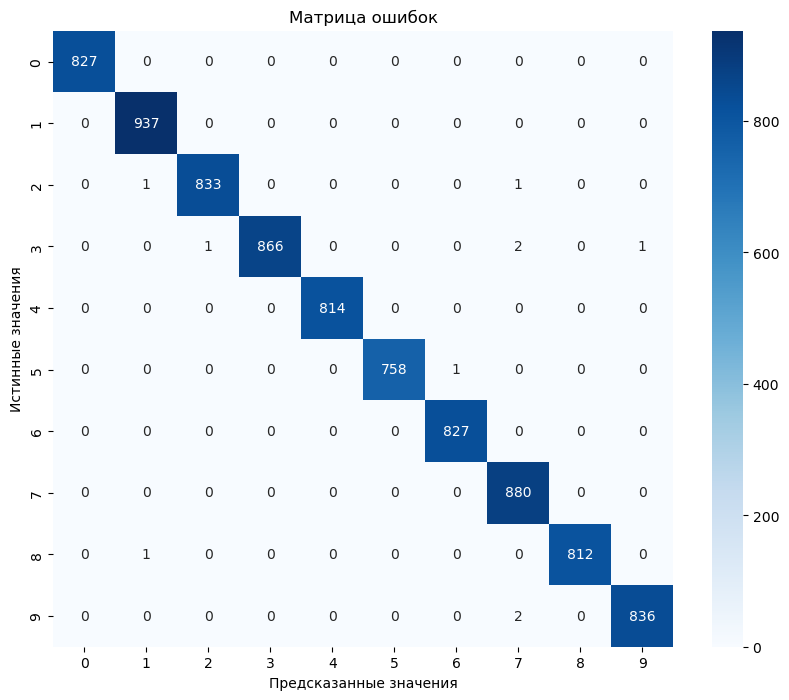

Подробный отчет по классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       827
           1       1.00      1.00      1.00       937
           2       1.00      1.00      1.00       835
           3       1.00      1.00      1.00       870
           4       1.00      1.00      1.00       814
           5       1.00      1.00      1.00       759
           6       1.00      1.00      1.00       827
           7       0.99      1.00      1.00       880
           8       1.00      1.00      1.00       813
           9       1.00      1.00      1.00       838

    accuracy                           1.00      8400
   macro avg       1.00      1.00      1.00      8400
weighted avg       1.00      1.00      1.00      8400



In [13]:
# Создание confusion matrix для оценки ошибок
from sklearn.metrics import confusion_matrix

# Предсказание на валидационной выборке
y_val_pred = rf_model.predict(X_val_scaled)
cm = confusion_matrix(y_val_split, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

# Подробный отчет по классификации
print("Подробный отчет по классификации:")
print(classification_report(y_val_split, y_val_pred))